<a href="https://colab.research.google.com/github/yashs79/financialaranomaly/blob/main/05_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

# pre-processing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# classification models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture

# performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import auc, roc_curve, average_precision_score, PrecisionRecallDisplay
np.random.seed(23)

import tensorflow as tf
from tensorflow.keras.models import Model

In [ ]:
raw_data = pd.read_csv('/content/creditcard.csv')

# Stratified Random Sampling
X_train_strat = pd.read_csv('/content//X_train_strat.csv')
X_test_strat = pd.read_csv('/content/X_test_strat.csv')
y_train_strat = pd.read_csv('/content/y_train_strat.csv')
y_test_strat = pd.read_csv('/content/y_test_strat.csv')

# Over Sampling
X_train_os = pd.read_csv('/content/X_train_os.csv')
X_test_os = pd.read_csv('/content/X_test_os.csv')
y_train_os = pd.read_csv('/content/y_train_os.csv')
y_test_os = pd.read_csv('/content/y_test_os.csv')

# Over Sampling with SMOTE
X_train_smote = pd.read_csv('/content/X_train_smote.csv')
X_test_smote = pd.read_csv('/content/X_test_smote.csv')
y_train_smote = pd.read_csv('/content/y_train_smote.csv')
y_test_smote = pd.read_csv('/content/y_test_smote.csv')

In [ ]:
def get_predictions(model, x_test_scaled, threshold):

    predictions = model.predict(x_test_scaled)

    # provides losses of individual instances
    errors = tf.keras.losses.mae(predictions, x_test_scaled)

    # 1 = anomaly, 0 = normal

    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    return preds

## 1. 30->16->8->4

In [ ]:
# 30 -> 25 -> 20 -> 15
class AutoEncoder(Model):

    def __init__(self):

        super(AutoEncoder, self).__init__()

        self.encoder = tf.keras.Sequential([
                       tf.keras.layers.Dense(24, activation="relu"),
                       tf.keras.layers.Dense(16, activation="relu"),
                       tf.keras.layers.Dense(8, activation="relu"),
                       tf.keras.layers.Dense(4, activation="relu"),
                       ])

        self.decoder = tf.keras.Sequential([
                       tf.keras.layers.Dense(8, activation="relu"),
                       tf.keras.layers.Dense(16, activation="relu"),
                       tf.keras.layers.Dense(24, activation="relu"),
                       tf.keras.layers.Dense(30, activation="sigmoid")
              ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
normal_train_data = X_train_strat[y_train_strat['Class'] == 0]
anomaly_train_data = X_train_strat[y_train_strat['Class'] == 1]
normal_test_data = X_test_strat[y_test_strat['Class'] == 0]
anomaly_test_data = X_test_strat[y_test_strat['Class'] == 1]

print(f'{X_train_smote.shape=}')
print(f'{X_train_os.shape=}')
print(f'{normal_train_data.shape=}')
print(f'{anomaly_test_data.shape=}')

model = AutoEncoder()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

model.compile(optimizer='adam', loss="mae")

history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(X_train_strat, X_train_strat),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

X_train_smote.shape=(398040, 30)
X_train_os.shape=(492, 30)
normal_train_data.shape=(199020, 30)
anomaly_test_data.shape=(148, 30)
Epoch 1/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6495 - val_loss: 0.6044
Epoch 2/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.5983 - val_loss: 0.5975
Epoch 3/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.5924 - val_loss: 0.5921
Epoch 4/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.5880 - val_loss: 0.5894
Epoch 5/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.5843 - val_loss: 0.5872
Epoch 6/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5828 - val_loss: 0.5848
Epoch 7/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5812 - val_loss: 0.5831
Epoch 8/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5789 - val_loss: 0.5822
Epoch 9/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5779 - val_loss: 0.5815
Epoch 10/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5784 - va

6220/6220 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


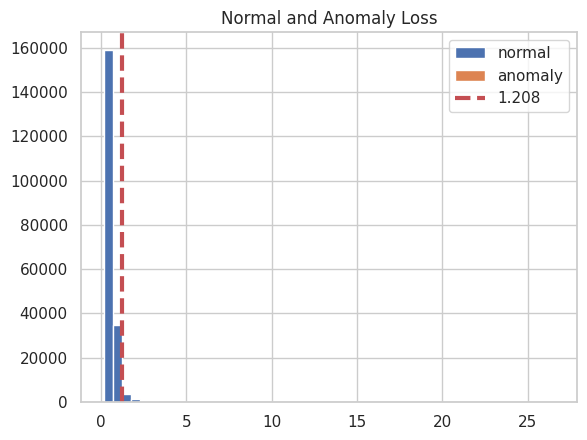

In [ ]:
reconstruction = model.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_train_data)

threshold = np.mean(train_loss) + 2*np.std(train_loss)

reconstruction_a = model.predict(anomaly_train_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_train_data)

plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [ ]:
np.min(train_loss), np.mean(train_loss), np.max(train_loss), stats.mode(train_loss, keepdims=False)[0]

(0.15737872039451875,
 0.5689630739980552,
 26.559567536388094,
 1.0029292650030568)

In [ ]:
np.quantile(train_loss, [0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

array([0.40276479, 0.51692222, 0.64612733, 0.8114695 , 0.98328155,
       1.77480123])

In [ ]:
np.mean(train_loss) + np.std(train_loss), np.mean(train_loss) + 2*np.std(train_loss)

(0.8883951278504986, 1.207827181702942)

In [ ]:
np.min(train_loss_a), np.mean(train_loss_a), np.max(train_loss_a), stats.mode(train_loss_a, keepdims=False)[0]

(0.2782123496050633, 2.8891272899749736, 11.027310436375256, 6.59667032315422)

In [ ]:
threshold0 = np.mean(train_loss)
threshold1 = np.mean(train_loss) + 1*np.std(train_loss)
threshold2 = np.mean(train_loss) + 2*np.std(train_loss)

In [ ]:
np.quantile(train_loss_a, [0.05, 0.1, 0.2, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

array([0.62522405, 0.80338387, 1.34553922, 1.48359713, 2.1797215 ,
       3.62511303, 6.19631888, 6.54606229, 8.35918959])

In [ ]:
print(f"Threshold: {threshold0}")

predictions = get_predictions(model, X_test_strat, threshold0)

print(confusion_matrix(y_test_strat, predictions))# Accuracy
print(classification_report(y_test_strat, predictions))

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test_strat, predictions)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

Threshold: 0.5689630739980552
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
[[51947 33348]
 [    9   139]]
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     85295
           1       0.00      0.94      0.01       148

    accuracy                           0.61     85443
   macro avg       0.50      0.77      0.38     85443
weighted avg       1.00      0.61      0.76     85443

0.47172269354196256


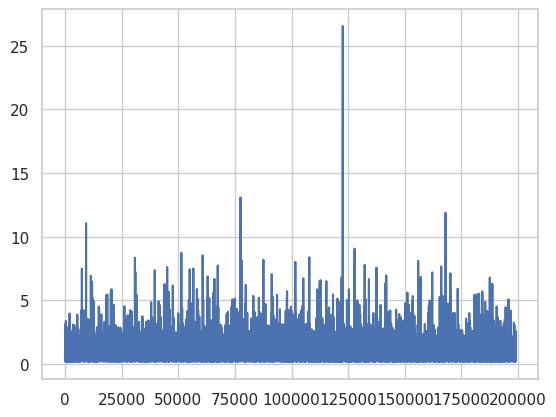

In [ ]:
plt.plot(train_loss)

In [ ]:
print(f"Threshold: {threshold1}")

predictions = get_predictions(model, X_test_strat, threshold1)

print(confusion_matrix(y_test_strat, predictions))# Accuracy
print(classification_report(y_test_strat, predictions))

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test_strat, predictions)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

Threshold: 0.8883951278504986
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
[[79238  6057]
 [   25   123]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     85295
           1       0.02      0.83      0.04       148

    accuracy                           0.93     85443
   macro avg       0.51      0.88      0.50     85443
weighted avg       1.00      0.93      0.96     85443

0.425638293212537


In [ ]:
print(f"Threshold: {threshold2}")

predictions = get_predictions(model, X_test_strat, threshold2)

print(confusion_matrix(y_test_strat, predictions))# Accuracy
print(classification_report(y_test_strat, predictions))

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test_strat, predictions)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

Threshold: 1.207827181702942
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
[[82870  2425]
 [   27   121]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.82      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.89      0.54     85443
weighted avg       1.00      0.97      0.98     85443

0.4327045489757656


In [ ]:
threshold3 = np.quantile(train_loss, 0.95)
print(f"Threshold: {threshold3}")

predictions = get_predictions(model, X_test_strat, threshold3)

print(confusion_matrix(y_test_strat, predictions))# Accuracy
print(classification_report(y_test_strat, predictions))

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test_strat, predictions)

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

Threshold: 0.9832815507582935
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
[[81000  4295]
 [   27   121]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     85295
           1       0.03      0.82      0.05       148

    accuracy                           0.95     85443
   macro avg       0.51      0.88      0.51     85443
weighted avg       1.00      0.95      0.97     85443

0.4226419650134263
